# Content

### 1. Neural Networks
### 2. Binary Classification
### 3. Multiclass Classification

## 1. Neural Networks
Neural networks are a type of computational model inspired by the structure and functioning of the human brain. Neural networks consist of interconnected nodes, known as artificial neurons or "nodes," which are organized in layers. These layers can be grouped into an input layer, one or more hidden layers, and an output layer.

Each artificial neuron receives input signals, performs a computation on them, and produces an output signal. The strength of the connections between neurons, represented by numerical values called weights, determines the influence of each input on the neuron's computation. Additionally, each neuron typically has an associated bias value that helps adjust the output.

The computations performed by neural networks are based on simple mathematical operations and activation functions. Activation functions introduce non-linearities into the system, enabling neural networks to model complex relationships between inputs and outputs.

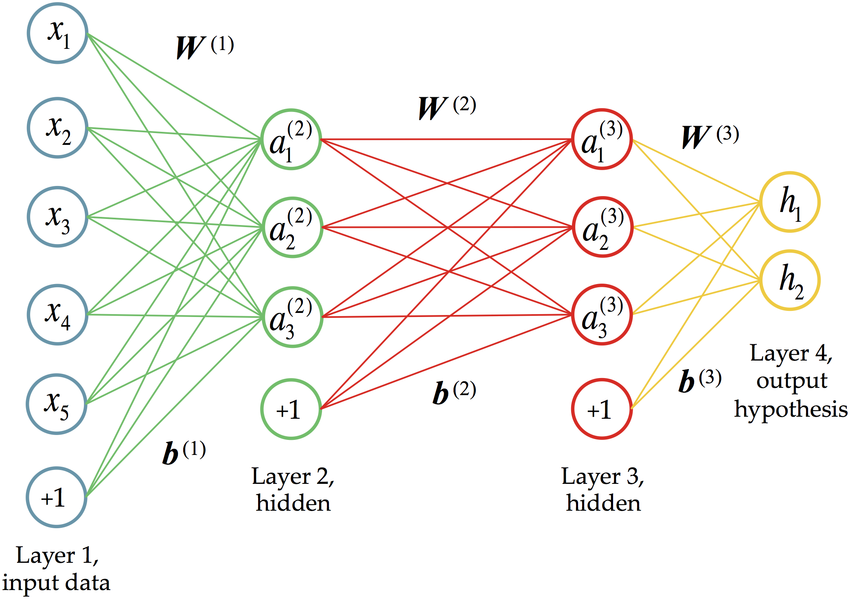

## Binary Classification

#### Let's see an example of neural network using Tensorflow and Keras

In [1]:
# temp: creation fo dataset, delete after created
import numpy as np
import pandas as pd

coffee_df = pd.read_csv('./data/coffee_roasting.csv')
coffee_df.head()

,Temperature,Time,Good_roast
0,185.317638,12.693965,1
1,259.920475,11.867664,0
2,231.013571,14.414242,0
3,175.366645,11.720587,0
4,187.120865,14.129732,1


#### Coffee roast data set
First let's load a coffee roasting data set, where we have two features: Time of roasting (in minutes) and Temperature of roasting (in Celsius). Target is whether the roast is good or bad. There is simple rule we know even before using neural network, but let's us try whether simple neural network can discover this rule base on our dataset.

Simple rules for good roast: <br>
1) best temperature: 175 - 260° <br>
2) best time: 12 - 15 min <br>
3) $ time <= \frac{-3}{(260-175)*temperature}+21 $ <br>

#### Visualization of the dataset

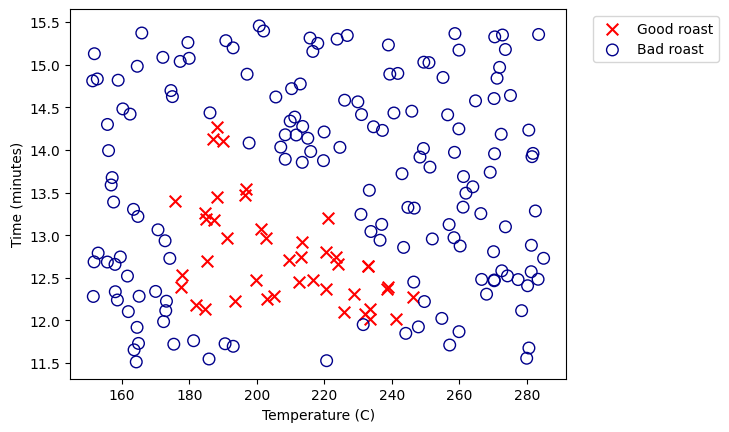

In [2]:
import matplotlib.pyplot as plt
good_roast = coffee_df[coffee_df['Good_roast']==1]; bad_roast = coffee_df[coffee_df['Good_roast']==0]

fix, ax = plt.subplots()
ax.scatter(good_roast.Temperature, good_roast.Time, s=70, marker='x', c='r', label='Good roast')
ax.scatter(bad_roast.Temperature, bad_roast.Time, s=70, marker='o', label='Bad roast', facecolors='none', edgecolors='darkblue')
ax.set(ylabel = 'Time (minutes)',
       xlabel = 'Temperature (C)')
ax.legend(loc='upper left', bbox_to_anchor=(1.04, 1), fancybox=True, ncol=1)
plt.show()

#### Now we will implement simple neural network using keras library. The NN will have only 1 hidden layer with 3 nodes and output layer returning a probability that the roast is good.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

tf.random.set_seed(1234)  # applied to achieve consistent results

#building a simple model
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name='layer1'),
        Dense(1, activation='sigmoid', name='layer2')
    ]
)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01),   #using legacy.Adam for mac M1, M2 otherwise use just .Adam
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Before we start to train the model we need to normalize feature columns.

In [4]:
X = coffee_df.iloc[:,:-1].to_numpy()
y = coffee_df.iloc[:,-1].to_numpy()

norm_1 = tf.keras.layers.Normalization(axis=-1)
norm_1.adapt(X)
X_n = norm_1(X)

##### Since our data set has only 200 records, we will oversample the whole population. Then we can youse less epochs to achieve good result

In [5]:
X_t = np.tile(X_n,(1000,1))
y_t = np.tile(y,(1000,)) 

model.fit(X_t, y_t, epochs=10, verbose=0)

In [6]:
w1, b1 = model.get_layer('layer1').get_weights()
w2, b2 = model.get_layer('layer2').get_weights()

print(f'layer 1 weights: \n{w1}')
print(f'layer 1 biases: \n{b1}')

print(f'layer 2 weights: \n{w2}')
print(f'layer 2 biases: \n{b2}')

layer 1 weights: 
[[ 13.796411   -10.820643    -0.09319124]
 [ 11.443535    -0.2290935   -8.561868  ]]
layer 1 biases: 
[  1.5420922 -11.8385    -10.756389 ]
layer 2 weights: 
[[-40.98848 ]
 [-45.618824]
 [-40.992157]]
layer 2 biases: 
[23.236313]


##### Now we have trained our model. Let's generate dataset of all possible temperatures and times to see how the model predicts whether the roast is good or bad

##### We can visualize it using a scale from 0 - 1 (probability) that for defined features the roast is good

In [7]:
#gen all possible data to predict
X_pred = np.mgrid[150:291:1, 11.5:15.6:0.1].reshape(2,-1).T

X_pred_t = norm_1(X_pred)   # normalize accoring to training data
y_pred = model.predict(X_pred_t)  #make prediction

181/181 [==============================] - 0s 235us/step


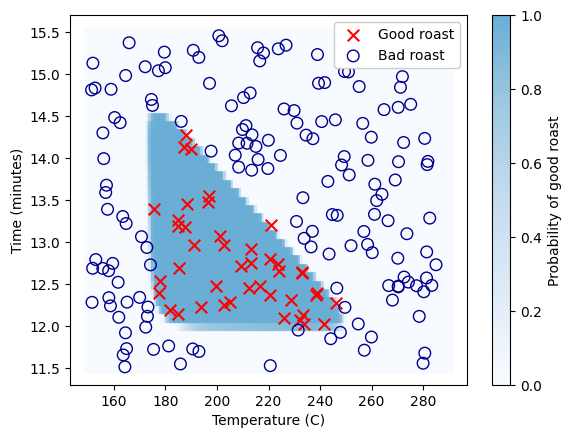

In [8]:
#visualize predictions as a heatmap
from matplotlib import cm
import matplotlib.colors as colors

# y_pred = y_pred.reshape(-1,)

#function helping to reduce undelying color
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#defining colors
cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap, 0.0, 0.5)

# plotting prediction map with training data
fig, ax = plt.subplots()
sc = ax.scatter(X_pred[:,0], X_pred[:,1], c=y_pred, cmap=new_cmap, marker='s', norm=cm.colors.Normalize(vmin=0, vmax=1))
ax.scatter(good_roast.Temperature, good_roast.Time, s=70, marker='x', c='r', label='Good roast')
ax.scatter(bad_roast.Temperature, bad_roast.Time, s=70, marker='o', label='Bad roast', facecolors='none', edgecolors='darkblue')
ax.set(ylabel = 'Time (minutes)',
       xlabel = 'Temperature (C)')
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1), fancybox=True, ncol=1, framealpha=1)
ax.figure.colorbar(sc, ax=ax, label= 'Probability of good roast')
plt.show()

### We can see that our simple model performs pretty well. The model was able to generalize the rules we set in in the begging and the shape with highest probaility of a good roast is a "triangle" fulfilling our rules.

## Now let's build our own NN to illustrate how neural networks work.

### Forward propagation in NumPy

In [9]:
# use activation function sigmoid
def sigmoid(x):
    return 1 / (1+ np.exp(-x))

def function_x(x, w, b):
    return np.dot(x, w) + b

# definition of a layer
def np_dense(a_in, W, B, activation):
    units = W.shape[1]
    a_out = np.zeros(units)

    a_out = activation(function_x(a_in, W, B))
    return a_out

# building of a sequential model
def np_sequential(x, w1, b1, w2, b2):
    l1 = np_dense(x, w1, b1, sigmoid)
    l2 = np_dense(l1, w2, b2, sigmoid)

    return l2

#### Now we have our layers and our model, let's use trained weight from tensorflow and see if our numpy model predicts same result

In [10]:
# prediction
y_pred_np = np_sequential(X_pred_t, w1, b1, w2, b2)    

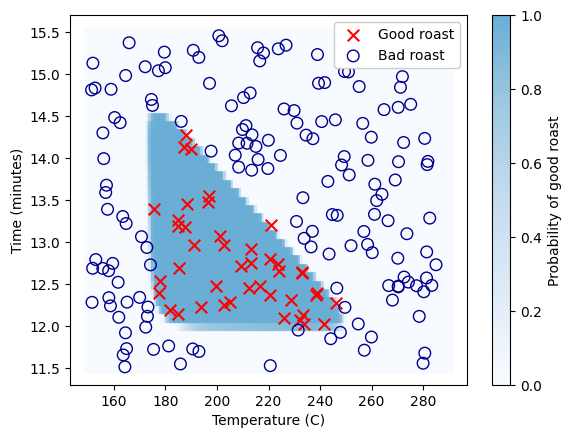

In [11]:
# plotting prediction map with training data => change c=y_pred_np - our new predictions
fig, ax = plt.subplots()
sc = ax.scatter(X_pred[:,0], X_pred[:,1], c=y_pred_np, cmap=new_cmap, marker='s', norm=cm.colors.Normalize(vmin=0, vmax=1))
ax.scatter(good_roast.Temperature, good_roast.Time, s=70, marker='x', c='r', label='Good roast')
ax.scatter(bad_roast.Temperature, bad_roast.Time, s=70, marker='o', label='Bad roast', facecolors='none', edgecolors='darkblue')
ax.set(ylabel = 'Time (minutes)',
       xlabel = 'Temperature (C)')
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1), fancybox=True, ncol=1, framealpha=1)
ax.figure.colorbar(sc, ax=ax, label= 'Probability of good roast')

##### Nice, the graph looks very similar! Now print whether get all predictions the same

In [12]:
print(((y_pred_np>=0.5).astype(int)==(y_pred>=0.5).astype(int)).all())

True


## Multiclass Classification

Before we move on an example of a multiclass classification let's have a look at activation function. So far we have used sigmoid activation function, which we know from logistic regression. However, in neural network model, professional often use ReLU activation function. Let's have a closer look on these two function.

### Activation function: Sigmoid vs ReLU
The Rectified Linear Unit (ReLU) activation function and the Sigmoid activation function are two commonly used activation functions in neural networks, and they have distinct characteristics that make them suitable for different scenarios.

The Rectified Linear Unit (ReLU) activation function is a popular choice in neural networks due to its simplicity and effectiveness. It is defined as the maximum of zero and the input value. ReLU introduces non-linearity by setting negative values to zero, while keeping positive values unchanged. This results in a sparse and more efficient representation, allowing the network to learn complex patterns and reduce the vanishing gradient problem. ReLU is computationally efficient, as it involves simple element-wise operations.

In comparison, the Sigmoid activation function is a smooth, S-shaped curve that squashes the input values between 0 and 1. It maps any real number to a range of probabilities, making it suitable for binary classification tasks. However, sigmoid suffers from the vanishing gradient problem, where gradients become extremely small for inputs far from zero, hindering the learning process. Sigmoid also has computational overhead due to the exponential calculation.

Overall, ReLU is often preferred over sigmoid due to its ability to mitigate the vanishing gradient problem and its computational efficiency, while the Sigmoid activation function is suitable for binary classification tasks and provides smooth gradients. Choosing the appropriate activation function depends on the specific task and network architecture, taking into account factors such as the presence of deep layers, computational efficiency requirements, and potential gradient-related challenges.

### Loss function

In previous example in tensorfow we used the BinaryCrossentropy() loss function in Keras. This loss function is commonly used in binary classification tasks, where the goal is to assign inputs to one of two classes. It measures the dissimilarity between the predicted probabilities and the true binary labels. 

Binary cross entropy is equivalent to the loss function we used in Logistic Regression example:
$$
L(f_{(\vec{w}, b)}(\vec{x}^{(i)}),y^{(i)}) =-y^{(i)}*\log(f_{\vec{w}, b}(\vec{x}^{(i)}))-(1-y^{(i)})*\log(1 - f_{\vec{w}, b}(\vec{x}^{(i)}))
$$

#### Softmax
However, we have to use modified version called <b>Softmax</b> when dealing with multiclass classification. It is designed to measure the difference between predicted probabilities and the true class labels. The softmax function takes as input a vector of real-valued scores and converts them into probabilities that sum up to one. In the context of the loss function, these probabilities represent the model's confidence in each class. The softmax loss function then compares these predicted probabilities with the true class labels using cross-entropy, which penalizes large deviations between the predicted and actual distributions. By minimizing the softmax loss, neural networks can effectively learn to assign higher probabilities to the correct classes, facilitating accurate classification.

Given a vector of scores, denoted as z, the softmax function calculates the probabilities p for each element in z as follows:

$ p_i = \frac{e^{z_i}}{\sum{e^{z_j}}} $ for j = 1 to N,

where N is the number of elements in z and $ p_i $ represents the probability assigned to the i-th element. The exponential function ($e$) ensures that the scores are positive, while the denominator normalizes the scores by summing up all the exponentiated scores, ensuring that the resulting probabilities add up to 1.

### Mnist Example
For multiclass classification we will you mnist dataset. Mnist data set is a public labled dataset of handwritten digits. We will learn our neural network to recognize handwritten digits. 

In [13]:
from tensorflow.keras.datasets import mnist
import warnings

warnings.filterwarnings('ignore')

(X_train, y_train), (X_pred, y_pred) = mnist.load_data()

11490434/11490434 [==============================] - 3s 0us/step


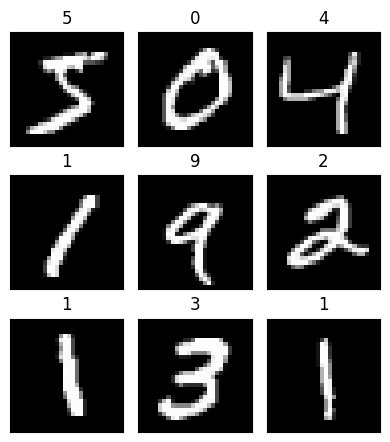

In [14]:
import math
#Let's visualize data

def visualize_digits(num_digits, n_cols):
    n_rows = math.ceil(num_digits / n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4, n_rows*1.5))
    
    for idx, ax in enumerate(axs.flatten()[:num_digits]):
        ax.imshow(X_train[idx], cmap='gray')
        ax.set(title=y_train[idx])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    if num_digits < n_rows * n_cols:
        for ax in axs.flatten()[num_digits:]:
            ax.remove()
    
    fig.tight_layout()
    plt.show()   
    
visualize_digits(9, 3)

In [54]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size

        self.weights = []
        self.biases = []


        for idx, hidden_size in enumerate(self.hidden_layers):
            # first hidden layer from input
            if idx==0:
                self.weights.append(np.random.randn(input_size, hidden_size))
                self.biases.append(np.zeros(hidden_size))
            else:
                self.weights.append(np.random.randn(self.hidden_layers[idx - 1], hidden_size))
                self.biases.append(np.zeros(hidden_size))

        # output layer
        self.weights.append(np.random.randn(self.hidden_layers[-1], output_size))
        self.biases.append(np.zeros(output_size))

    def forward(self, X):
        layer_input = X
        
        for idx, hidden_layer in enumerate(self.hidden_layers):
            layer_output = self.relu(self.fuction_x(layer_input, self.weights[idx], self.biases[idx]))
            layer_input = layer_output

        output = self.softmax(fuction_x(layer_input, self.weights[-1], self.biases[-1]))

        return output

    def backpropagation(self, X, y):
        pass

    def function_x(self, x, w, b):
        return np.dot(x, w) + b

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, X):
        # Softmax activation function
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def show_parameters(self):
        print('='*4,'Input Layer','='*10, '\n')
        print(f'Input size: {self.input_size}', '\n')
        
        for idx, hidden_layer in enumerate(self.hidden_layers):
            print('='*4,f'Hidden Layer {idx+1}','='*10, '\n')
            print(f'Weights: {self.weights[idx].shape} \n', self.weights[idx])
            print(f'Biases: {self.biases[idx].shape} \n', self.biases[idx], '\n')

        print('='*4,'Output Layer','='*10, '\n')
        print(f'Weights: {self.weights[-1].shape} \n', self.weights[-1])
        print(f'Biases: {self.biases[-1].shape} \n', self.biases[-1])
                
            


In [55]:
nw = NeuralNetwork(3, [4, 5, 8], 2)
nw.show_parameters()

==== Input Layer ========== 

Input size: 3 

==== Hidden Layer 1 ========== 

Weights: (3, 4) 
 [[-1.27577231 -0.96313215 -0.44092746 -0.79165836]
 [ 0.584355    0.35895965 -1.32246516 -1.38952134]
 [-0.86442712  0.71648688 -0.92146707 -0.1140784 ]]
Biases: (4,) 
 [0. 0. 0. 0.] 

==== Hidden Layer 2 ========== 

Weights: (4, 5) 
 [[-0.33245364  0.7016276  -0.5710436  -0.10602757  0.66427693]
 [ 0.01927989  0.34089235 -1.20943404 -0.19783799  1.30188299]
 [ 0.30701827  0.26277559 -0.17408814 -0.97123022  0.68568881]
 [ 0.57640149 -0.15474704  0.28034013 -0.74601864 -1.13100951]]
Biases: (5,) 
 [0. 0. 0. 0. 0.] 

==== Hidden Layer 3 ========== 

Weights: (5, 8) 
 [[ 0.32862399  0.58737672  0.54403873  0.71407232  0.71656449  0.14462394
  -0.6795604  -0.12804   ]
 [ 0.30340918 -1.02021969  1.25586597 -0.3936853   0.63488918  1.20515595
  -1.41063101  0.53572087]
 [-0.38830421  0.41399755  0.45032114 -1.13597481  1.13484011 -1.50924389
   0.04588629  0.36425193]
 [-1.14622893 -0.99744896 

==== Hidden Layer 1 ========== 

Weights: (3, 4) 
 [[-1.82384466  0.23456711 -2.45985441 -0.70266014]
 [ 1.2217146  -1.27164436 -0.6957708  -2.31175105]
 [ 0.00768083  1.29526949  0.79221078 -0.67450819]]
Biases: (4,) 
 [0. 0. 0. 0.]
==== Hidden Layer 2 ========== 

Weights: (4, 5) 
 [[-0.17332657 -0.14590712  1.15208663 -0.17452279 -0.30709548]
 [-0.55091191 -1.27076723  1.60096663  1.78678201 -0.15132423]
 [-0.05397526  1.43957904 -0.88922949  2.21765205 -0.69486168]
 [ 1.29280998  0.22025889  1.69136708  0.19306468  1.4440809 ]]
Biases: (5,) 
 [0. 0. 0. 0. 0.]
